In [6]:

%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from tqdm import tqdm, trange

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

import matplotlib.pyplot as plt

In [ ]:
# #Load the dataset
# dataset = 'cora'
# path = os.path.join(os.getcwd(), 'data', 'Planetoid')
# train_dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())

# # Since the dataset is comprised of a single huge graph, we extract that graph by indexing 0.
# data = train_dataset[0]

# # Since there is only 1 graph, the train/test split is done by masking regions of the graph. We split the last 500+500 nodes as val and test, and use the rest as the training data.
# data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# data.train_mask[:data.num_nodes - 1000] = 1
# data.val_mask = None
# data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# data.test_mask[data.num_nodes - 500:] = 1

In [27]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print('dataset under study')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Number of graphs: 1
Number of features: 1433
Number of classes: 7
dataset under study
Number of nodes: 2708
Number of edges: 10556


In [2]:
# import kgbench as kg
# data = kg.load('aifb', torch=True) 
# print(f'Number of entities: {data.num_entities}') #data.i2e
# print(f'Number of classes: {data.num_classes}')
# print(f'Types of relations: {data.num_relations}') #data.i2r


from torch_geometric.datasets import Entities
from torch_geometric.nn import FastRGCNConv, RGCNConv
from torch_geometric.utils import k_hop_subgraph

path = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/../data/Entities' #osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Entities')
dataset = Entities(path, 'AIFB')
data = dataset[0]

# BGS and AM graphs are too big to process them in a full-batch fashion.
# Since our model does only make use of a rather small receptive field, we
# filter the graph to only contain the nodes that are at most 2-hop neighbors
# away from any training/test node.
node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 2, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]


data.train_mask = [True if i in data.train_idx else False for i in range(data.num_nodes)]
data.test_mask = [True if i in data.test_idx else False for i in range(data.num_nodes)]
data.train_mask
data.x = torch.zeros(data.num_nodes, 3)

In [ ]:
# class Net(torch.nn.Module):
#     def __init__(self, num_features, dim=16, num_classes=1):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(num_features, dim)
#         self.conv2 = GCNConv(dim, num_classes)

#     def forward(self, x, edge_index, data=None):
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

In [14]:
#DEFINE THE MODEL
class Net(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, output_dim)

    def forward(self, x,edge_index, data = None):
        #edge_index = adj.nonzero().t()
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    

    
input_dim = dataset.num_features
output_dim = dataset.num_classes


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(input_dim, output_dim).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(aifb = False):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out= model(data.x, data.edge_index)  # Perform a single forward pass.
    
    if aifb:
        loss = criterion(out[data.train_mask], data.train_y)
    else:
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.  
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test(aifb = False):
    model.eval()
    out= model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    if aifb:
        test_correct = pred[data.test_mask] == data.test_y # Check against ground-truth labels.
        test_incorrect = pred[data.test_mask] != data.test_y # Check against ground-truth labels.
        print(test_incorrect)
        test_acc = int(test_correct.sum()) / len(data.test_y)
        torch.save(out, 'pred_aifb')
    else:    
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        test_incorrect = pred[data.test_mask] != data.y[data.test_mask] # Check against ground-truth labels.
    
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        torch.save(out, './cora_chk/prediction_cora')
    
    return test_acc


for epoch in tqdm(range(1, 401)):
    loss = train()

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}') 


model.eval()
pred= model(data.x, data.edge_index)
torch.save(model, './cora_chk/model_cora')
#torch.save(model, 'model_aifb')

100%|██████████| 400/400 [00:04<00:00, 81.63it/s]

Test Accuracy: 0.8080


In [6]:
mislabeled = []
correct = []
for i in range(1000):
    if torch.load('../cora_chk/prediction_cora').argmax(dim=1)[i] != data.y[i]:
        #print(i, pred_label[i], data.y[i])
        mislabeled.append(i)
    else:
        correct.append(i)
print('mislabeled:',mislabeled)        

mislabeled: [141, 147, 161, 162, 167, 168, 172, 184, 191, 192, 224, 225, 240, 250, 252, 254, 255, 256, 260, 267, 272, 277, 278, 280, 285, 287, 291, 292, 293, 300, 311, 319, 320, 323, 332, 342, 354, 356, 365, 376, 377, 380, 383, 388, 397, 398, 401, 404, 417, 433, 435, 436, 438, 446, 454, 461, 462, 465, 467, 471, 473, 474, 476, 477, 478, 480, 490, 496, 498, 502, 503, 506, 512, 516, 517, 518, 520, 522, 530, 531, 548, 553, 554, 555, 571, 573, 574, 576, 578, 581, 590, 591, 592, 597, 600, 603, 606, 611, 614, 617, 626, 628, 630, 641, 642, 644, 645, 659, 670, 674, 675, 678, 680, 695, 696, 699, 702, 711, 717, 724, 728, 733, 738, 743, 749, 753, 755, 756, 760, 767, 768, 772, 776, 780, 791, 794, 798, 803, 818, 822, 827, 832, 842, 843, 849, 852, 854, 863, 865, 868, 872, 873, 876, 880, 896, 903, 906, 913, 917, 930, 931, 934, 939, 940, 943, 945, 948, 949, 952, 953, 968, 973, 974, 979, 989, 992, 993, 995]


In [ ]:
node_idx = 0
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

In [ ]:
len(data.x.size())

In [ ]:
y = model(data.x, data.edge_index, data)
res_full, predlabel_full = nn.Softmax(dim=0)(y[node_idx, :]), torch.argmax(nn.Softmax(dim=0)(y[node_idx, :]))


In [3]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, output_dim)

    def forward(self, x,edge_index, data = None):
        #edge_index = adj.nonzero().t()
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [16]:
model = torch.load('./cora_chk/model_cora')
#model = torch.load('model_aifb')

for node_idx in [0]:
#explainer boy

      x, edge_index = data.x, data.edge_index
      print(x.shape, edge_index.shape)
      explainer = GNNExplainer(model)
      node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
      print(edge_mask)
      #Full Results
      y = model(data.x, data.edge_index, data)
      res_full, predlabel_full = nn.Softmax(dim=0)(y[node_idx, :]), torch.argmax(nn.Softmax(dim=0)(y[node_idx, :]))


      #Explained results
      indices = edge_mask.to_sparse().indices()
      edge_mask.to_sparse().values()
      i = data.edge_index.t()[indices].squeeze().t()
      v = edge_mask.to_sparse().values()
      e = torch.sparse_coo_tensor(i ,v )

      ypred = model(data.x,i, data)
      print('edge mask;', edge_mask.to_sparse())
      res, predlabel = nn.Softmax(dim=0)(ypred[node_idx, :]), torch.argmax(nn.Softmax(dim=0)(ypred[node_idx, :]))



      print('true label:', data.y[node_idx], '\n full model pred label:' ,predlabel_full, '\n full model pred prob:', res_full[predlabel_full], '\n size of full graph:', len(data.edge_index[0]),
            '\n explained pred label:',predlabel, '\n explained pred prob:', res[predlabel], '\n size of explained graph:', len(i[0]))


      # print('true label:', data.test_y[node_idx], '\n full model pred label:' ,predlabel_full, '\n full model pred prob:', res_full[predlabel_full], '\n size of full graph:', len(data.edge_index[0]),
      #       '\n explained pred label:',predlabel, '\n explained pred prob:', res[predlabel], '\n size of explained graph:', len(i[0]))

torch.Size([2708, 1433]) torch.Size([2, 10556])
features
<class 'int'> <class 'int'> <class 'int'>
2708 1433 10556
explanation: Explanation(x=[2708, 1433], edge_index=[2, 10556], edge_mask=[10556], node_feat_mask=[2708, 1433])
tensor([0.7199, 0.7134, 0.7199,  ..., 0.0000, 0.0000, 0.0000])
edge mask; tensor(indices=tensor([[    0,     1,     2,  2569,  2570,  2571,  3637,  4551,
                         6751,  6787,  6791,  7565,  7566,  7567,  7568,  7578,
                         7579, 10306, 10307, 10308]]),
       values=tensor([0.7199, 0.7134, 0.7199, 0.7160, 0.2791, 0.2728, 0.7189,
                      0.7317, 0.2841, 0.2909, 0.2749, 0.7137, 0.2771, 0.2656,
                      0.7242, 0.7247, 0.2770, 0.7310, 0.2772, 0.6494]),
       size=(10556,), nnz=20, layout=torch.sparse_coo)
true label: tensor(3) 
 full model pred label: tensor(3) 
 full model pred prob: tensor(0.9332, grad_fn=<SelectBackward0>) 
 size of full graph: 10556 
 explained pred label: tensor(3) 
 explained pred

In [18]:
from RGCN_stuff.rgcn_explainer_utils import dict_index_classes, dict_triples_semantics, selected, visualize, find_n_hop_neighbors, match_to_classes, match_to_triples, edge_index_oneadj, get_relations, d_classes, encode_dict
import networkx as nx
import numpy as np
from collections import Counter

[[   0  633]
 [   0 1862]
 [   0 2582]
 [ 633    0]
 [ 633 1701]
 [ 633 1866]
 [ 926 1862]
 [1166 2582]
 [1701  633]
 [1701 1862]
 [1701 1866]
 [1862    0]
 [1862  926]
 [1862 1701]
 [1862 2582]
 [1866  633]
 [1866 1701]
 [2582    0]
 [2582 1166]
 [2582 1862]]
tensor([3, 3, 3, 3, 3, 3, 3, 3])


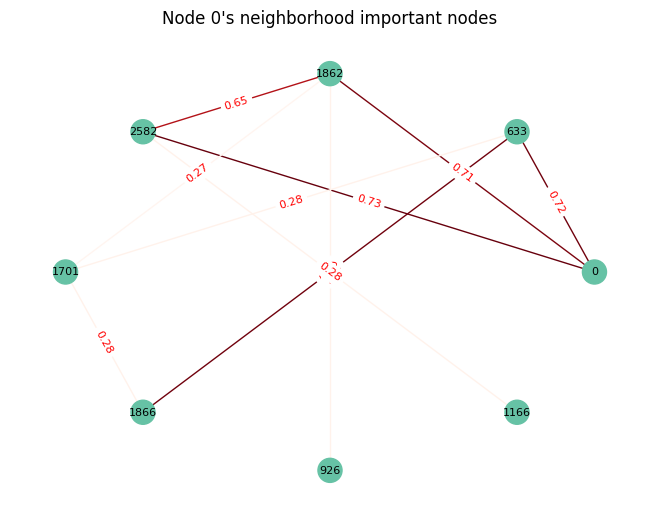

In [20]:
import numpy as np
def visualize(node_idx, data, masked_ver,result_weights=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    #dict_index = dict_index_classes(data,masked_ver)
    sel_masked_ver = masked_ver
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes
    print(new_index)
    sub_edges, neighborhoods, sub_edges_tensor = find_n_hop_neighbors(data.edge_index, 2, node=0)
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().detach().numpy()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:
        #get triples to get relations 
        triples_matched = match_to_triples(np.array(new_index), data.triples)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        print(Counter(l))
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=int(p))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())


    pos = nx.circular_layout(G)

    # ordered_dict = {}
    # for item in list(G.nodes):
    #     if item in ordered_dict:
    #         ordered_dict[item].append(dict_index[item])
    #     else:
    #         ordered_dict[item] =  dict_index[item]

    # dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  


    print(data.y[list(neighborhoods)])
    
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=weights,  node_color = data.y[list(neighborhoods)],cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')

        plt.title("Node {}'s neighborhood important nodes".format(node_idx))
    else:
        rel = nx.get_edge_attributes(G,'weight')
        for k,v in rel.items():
            rel[k] = data.i2rel[v][0]
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=weights, node_color = data.y[neighborhoods], cmap="Set2",font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=8,font_color='red')

        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        res = Counter(rel.values())
    if result_weights:
        plt.savefig(f'aifb_chk/graphs/Explanation_{node_idx}_weights.png')
        plt.show()
    else:
        plt.savefig(f'aifb_chk/graphs/Explanation_{node_idx}_relations.png')    
        plt.show()
        return res

    
visualize(0, data, e, result_weights=True)  

Probably can do explanation on RGCN like this, here, so innocently OKKKKKKK BROOOOOOOOOOOOOO MY WHOLE LIFE IDK LMAO

In [7]:
# import kgbench as kg
# data = kg.load('aifb', torch=True) 
# print(f'Number of entities: {data.num_entities}') #data.i2e
# print(f'Number of classes: {data.num_classes}')
# print(f'Types of relations: {data.num_relations}') #data.i2r


from torch_geometric.datasets import Entities
from torch_geometric.nn import FastRGCNConv, RGCNConv
from torch_geometric.utils import k_hop_subgraph

path = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/../data/Entities' #osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Entities')
dataset = Entities(path, 'AIFB')
data = dataset[0]

# BGS and AM graphs are too big to process them in a full-batch fashion.
# Since our model does only make use of a rather small receptive field, we
# filter the graph to only contain the nodes that are at most 2-hop neighbors
# away from any training/test node.
node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 2, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]

In [13]:
data.

In [35]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F



# Trade memory consumption for faster computation.
#if args.dataset in ['AIFB', 'MUTAG']:
RGCNConv = FastRGCNConv




class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = RGCNConv(data.num_nodes, 16, dataset.num_relations,
                              num_bases=30)
        self.conv2 = RGCNConv(16, dataset.num_classes, dataset.num_relations,
                              num_bases=30)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)
    

    def forward(self):
        edge_index, edge_type = data.edge_index, data.edge_type
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

    def forward(self, edge_type, edge_index):
        #edge_type edge_type.unsqueeze(1)
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')# if args.dataset == 'AM' else device
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)




In [36]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_type, data.edge_index )
    #out = model()
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_type ,data.edge_index).argmax(dim=-1)
    #pred = model().argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    torch.save(pred[data.test_idx], 'aifb_chk/prediction_aifb')
    return train_acc, test_acc


for epoch in range(1, 51):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')
    
torch.save(model, 'aifb_chk/model_aifb')    

Epoch: 01, Loss: 1.3797, Train: 0.9500 Test: 0.7778
Epoch: 02, Loss: 0.7786, Train: 0.9643 Test: 0.8056
Epoch: 03, Loss: 0.3324, Train: 0.9714 Test: 0.9167
Epoch: 04, Loss: 0.1416, Train: 0.9786 Test: 0.9167
Epoch: 05, Loss: 0.0753, Train: 0.9857 Test: 0.9722
Epoch: 06, Loss: 0.0467, Train: 0.9857 Test: 0.9722
Epoch: 07, Loss: 0.0292, Train: 0.9929 Test: 0.9722
Epoch: 08, Loss: 0.0165, Train: 1.0000 Test: 0.9722
Epoch: 09, Loss: 0.0083, Train: 1.0000 Test: 0.9722
Epoch: 10, Loss: 0.0043, Train: 1.0000 Test: 0.9722
Epoch: 11, Loss: 0.0027, Train: 1.0000 Test: 0.9722
Epoch: 12, Loss: 0.0022, Train: 1.0000 Test: 0.9722
Epoch: 13, Loss: 0.0018, Train: 1.0000 Test: 0.9722
Epoch: 14, Loss: 0.0016, Train: 1.0000 Test: 0.9722
Epoch: 15, Loss: 0.0013, Train: 1.0000 Test: 0.9722
Epoch: 16, Loss: 0.0011, Train: 1.0000 Test: 0.9722
Epoch: 17, Loss: 0.0010, Train: 1.0000 Test: 0.9722
Epoch: 18, Loss: 0.0008, Train: 1.0000 Test: 0.9722
Epoch: 19, Loss: 0.0007, Train: 1.0000 Test: 0.9722
Epoch: 20, L

In [ ]:
data.num_nodes

In [ ]:
mislabeled = []
correct = []
for i in range(36):
    if torch.load('aifb_chk/prediction_aifb')[i] != data.test_y[i]:
        #print(i, pred_label[i], data.y[i])
        mislabeled.append(i)
    else:
        correct.append(i)
print('mislabeled:',mislabeled)  

In [ ]:
data.x = torch.zeros(data.num_nodes, 3, dtype=torch.int64)
#data.edge_type = data.edge_type.unsqueeze(1)
data.edge_type.shape

In [25]:
data.edge_index = data.edge_index.to(torch.int64)
data.edge_type = data.edge_type.to(torch.int64)
print(data.edge_index.dtype)

torch.int64


In [26]:
for node_idx in [0]:
#explainer boy

      x, edge_index = data.edge_type, data.edge_index
      print(x.shape, edge_index.shape)
      print(type(x))
      explainer = GNNExplainer(model, node_feat_mask = False, edge_mask = True)
      node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
      #edge_mask = explainer.explain_node(node_idx)

      #Full Results
      y = model(data.x, data.edge_index, data)
      #y = model()
      res_full, predlabel_full = nn.Softmax(dim=0)(y[node_idx, :]), torch.argmax(nn.Softmax(dim=0)(y[node_idx, :]))


      #Explained results
      indices = edge_mask.to_sparse().indices()
      edge_mask.to_sparse().values()
      i = data.edge_index.t()[indices].squeeze().t()
      v = edge_mask.to_sparse().values()
      e = torch.sparse_coo_tensor(i ,v )

      ypred = model(data.x,i, data)
      res, predlabel = nn.Softmax(dim=0)(ypred[node_idx, :]), torch.argmax(nn.Softmax(dim=0)(ypred[node_idx, :]))

      print('true label:', data.y[node_idx], '\n full model pred label:' ,predlabel_full, '\n full model pred prob:', res_full[predlabel_full], '\n size of full graph:', len(data.edge_index[0]),
            '\n explained pred label:',predlabel, '\n explained pred prob:', res[predlabel], '\n size of explained graph:', len(i[0]))


torch.Size([54024]) torch.Size([2, 54024])
<class 'torch.Tensor'>
no features
<class 'int'> <class 'int'> <class 'int'>
54024 1 54024


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'nn.models.GNNExplainer' is deprecated, use 'explain.Explainer' with 'explain.algorithm.GNNExplainer' instead
  warnings.warn(out)


IndexError: tensors used as indices must be long, byte or bool tensors

In [9]:
from RGCN_stuff.rgcn_model import adj, enrich, sum_sparse, RGCN

model = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/aifb_chk/model_aifb')


In [ ]:
def hor_ver_graph(triples, n, r):
    """ 
    input: triples, number of nodes, number of relations
    output: hor_graph, ver_graph : horizontally and vertically stacked adjacency matrix
    """
    #triples = enrich(triples_small, n, r)

    hor_ind, hor_size = adj(triples, n, 2*r+1, vertical=False)
    ver_ind, ver_size = adj(triples, n, 2*r+1, vertical=True)
    #number of relations is 2*r+1 because we added the inverse and self loop

    _, rn = hor_size #horizontally stacked adjacency matrix size
    print(hor_size)
    r = rn // n #number of relations enriched divided by number of nodes

    vals = torch.ones(ver_ind.size(0), dtype=torch.float) #number of enriched triples
    vals = vals / sum_sparse(ver_ind, vals, ver_size) #normalize the values by the number of edges

    hor_graph = torch.sparse.FloatTensor(indices=hor_ind.t(), values=vals, size=hor_size) #size: n,r, emb


    ver_graph = torch.sparse.FloatTensor(indices=ver_ind.t(), values=vals, size=ver_size)

    return hor_graph, ver_graph

hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
ver_graph.coalesce().values()

In [ ]:
n, rn = ver_graph.coalesce().indices().size()

In [ ]:
len(data.i2e)

In [ ]:

for node_idx in [0]:
#explainer boy

      x, edge_index = ver_graph.coalesce().values(), ver_graph.coalesce().indices()
      explainer = GNNExplainer(model)
      node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
      #edge_mask = explainer.explain_node(ver_graph)

      #Full Results
      y = model.forward3(ver_graph)
      res_full, predlabel_full = nn.Softmax(dim=0)(y[node_idx, :]), torch.argmax(nn.Softmax(dim=0)(y[node_idx, :]))


      #Explained results
      indices = edge_mask.to_sparse().indices()
      edge_mask.to_sparse().values()
      i = data.edge_index.t()[indices].squeeze().t()
      v = edge_mask.to_sparse().values()
      e = torch.sparse_coo_tensor(i ,v )

      ypred = model.forward3(i)
      res, predlabel = nn.Softmax(dim=0)(ypred[node_idx, :]), torch.argmax(nn.Softmax(dim=0)(ypred[node_idx, :]))

      print('true label:', data.y[node_idx], '\n full model pred label:' ,predlabel_full, '\n full model pred prob:', res_full[predlabel_full], '\n size of full graph:', len(data.edge_index[0]),
            '\n explained pred label:',predlabel, '\n explained pred prob:', res[predlabel], '\n size of explained graph:', len(i[0]))


In [29]:
path = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/../data/Entities' #osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Entities')
dataset = Entities(path, 'AIFB')
data = dataset[0]

# BGS and AM graphs are too big to process them in a full-batch fashion.
# Since our model does only make use of a rather small receptive field, we
# filter the graph to only contain the nodes that are at most 2-hop neighbors
# away from any training/test node.
node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 2, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]


data.train_mask = [True if i in data.train_idx else False for i in range(data.num_nodes)]
data.test_mask = [True if i in data.test_idx else False for i in range(data.num_nodes)]
data.train_mask
data.x = torch.zeros(data.num_nodes, 3)

In [33]:
data.edge_type

tensor([13, 13, 13,  ...,  0,  5,  2])

In [41]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

# dataset = 'Cora'
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
# dataset = Planetoid(path, dataset)
# data = dataset[0]


# class Net(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = GCNConv(dataset.num_features, 16)
#         self.conv2 = GCNConv(16, dataset.num_classes)

#     def forward(self, x, edge_index, edge_weight):
#         x = F.relu(self.conv1(x, edge_index, edge_weight))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         return F.log_softmax(x, dim=1)

import argparse
import os.path as osp

import torch
import torch.nn.functional as F



# Trade memory consumption for faster computation.
#if args.dataset in ['AIFB', 'MUTAG']:
RGCNConv = FastRGCNConv




class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = RGCNConv(data.num_nodes, 16, dataset.num_relations,
                              num_bases=30)
        self.conv2 = RGCNConv(16, dataset.num_classes, dataset.num_relations,
                              num_bases=30)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)
    

    def forward(self):
        edge_index, edge_type = data.edge_index, data.edge_type
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

    def forward(self, edge_type, edge_index):
        #edge_type edge_type.unsqueeze(1)
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')# if args.dataset == 'AM' else device
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# data = data.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.edge_type, data.edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.train_y)
    loss.backward()
    optimizer.step()



explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explainer_config=dict(
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
    ),
    model_config=dict(
        mode='classification',
        task_level='node',
        return_type='log_probs',
    ),
)
node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index,
                        edge_weight=data.edge_weight)
print(f'Generated explanations in {explanation.available_explanations}')

TypeError: forward() got an unexpected keyword argument 'x'